# 移動平均モデル（MAモデル）

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

## 訓練データ生成

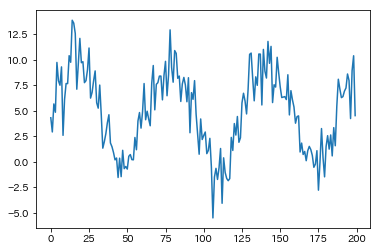

In [2]:
xx = np.arange(200)
xx = 5 * np.sin(0.1 * xx) + 2 * np.random.normal(size=200) + 5.
plt.plot(xx)

## 学習

MAモデルは直前の誤差の重ね合わせ、つまり$x_{s} = \theta_{0}+ \sum_{j=1}^{m} \theta_{j} \epsilon_{s-j} + \epsilon_{s}$で与えられる。

ただし、$\theta_{j}$は重みパラメータ、$\epsilon_{i}$は時刻$i$でのノイズであり平均$0$、分散$\sigma^{2}$の正規分布に従うと仮定する。すると、$\mathbb{E}[x]=\theta_{0}$が成り立つ。

また、このとき$p(x_{s}|\epsilon_{s-1}, \epsilon_{s-2}, .., \epsilon_{s-m}; \boldsymbol{\theta}, \sigma^{2}) = \mathcal{N}(x_{s} | \theta_{0}+ \sum_{j=1}^{m} \theta_{j} \epsilon_{s-j}, \sigma^{2})$とかける。パラメータを最尤推定より求める。対数尤度関数は、

\begin{eqnarray}
\log{p(X | \boldsymbol{\theta}, \sigma^{2})} &=& \prod_{s=1}^{n} p(x_{s} | \epsilon_{s-1}, \epsilon_{s-2}, .., \epsilon_{s-m}; \boldsymbol{\theta}, \sigma^{2}) \\
&=& \sum_{s=1}^{n} [-\frac{1}{2}\log{2 \pi} - \frac{1}{2}\log{\sigma^{2}} - \frac{1}{2 \sigma^{2}} (x_{s} - \theta_{0} - \sum_{j=1}^{m} \theta_{j} \epsilon_{s-j})^{2}] \\
&=& \sum_{s=1}^{n} [-\frac{1}{2}\log{2 \pi} - \frac{1}{2}\log{\sigma^{2}} - \frac{\epsilon_{s}^{2}}{2 \sigma^{2}} ]
\end{eqnarray}

となる。ただし、$\epsilon_{i}=0 (i \le 0)$とする。各パラメータで偏微分すると、

\begin{eqnarray}
\frac{\partial}{\partial \theta_{i}} (\log{p(X | \boldsymbol{\theta}, \sigma^{2})}) &=& \frac{1}{\sigma^{2}} \sum_{s=1}^{n} \epsilon_{s} \epsilon_{s-i} \\
\frac{\partial}{\partial \sigma^{2}} (\log{p(X | \boldsymbol{w}, \sigma^{2})}) &=& -\frac{n}{\sigma} + \frac{1}{\sigma^{3}} \sum_{s=1}^{n} \epsilon_{s}^{2} \qquad (i=1, 2, .., m)
\end{eqnarray}

$\epsilon_{i}$が$\boldsymbol{\theta}$に依存するので、閉じた解として求まらないので以下のステップで求める。

1. $\boldsymbol{\theta}$を初期化する

2. バックキャストで$\tilde{\epsilon}_{i} (i=n, n-1, .., 1)$を求める。($\tilde{\epsilon}_{i} = x_{i} - \theta_{0} - \sum_{j=1}^{m} \theta_{j} \tilde{\epsilon}_{i+j}　\qquad \tilde{\epsilon}_{i} = 0 (i \le 0, n+1 \le i)$)

3. 2の結果を利用して順方向に$\hat{\epsilon}_{i} (i=1, 2, .., n)$を求める。($\hat{\epsilon}_{i} = x_{i} - \theta_{0} - \sum_{j=1}^{m} \theta_{j} \tilde{\epsilon}_{i-j} \qquad (i \ge n) \qquad \hat{\epsilon}_{i} = 0 (i \le 0)$)

4. 以下の式でパラメータを更新する。
\begin{eqnarray}
\sigma^{2} &=& \frac{1}{n} \sum_{s=1}^{n} \hat{\epsilon}_{s}^{2} \\
\theta_{i} &\leftarrow& \theta_{i} + \eta \frac{\partial}{\partial \theta_{i}} (\log{p(X | \boldsymbol{\theta}, \sigma^{2})}) = \theta_{i} + \frac{\eta}{\sigma^{2}} \sum_{s=1}^{n} \hat{\epsilon}_{s} \hat{\epsilon}_{s-i} \qquad (i=1, 2, .., m)
\end{eqnarray}

5. 収束すれば終了。そうでなければ、2へ。

In [3]:
x_train = xx
n = len(x_train)
m = 2
theta0 = np.mean(x_train)

e_tilde = np.zeros(n+2*m)
e_hat = np.zeros(n+m)

def backcast(theta):
    for i in reversed(range(n)):
        e_tilde[m+i] = x_train[i] - theta0 - np.dot(theta, e_tilde[m+i+1: i+2*m+1])

def forward(theta):
    eps = np.array([e_tilde[i:i+m][::-1] for i in range(n)])
    e_hat[m:] = x_train - theta0 - np.dot(eps, theta)
    e_hat[m:] = e_hat[m:]

In [4]:
max_iter = 1000
leaning_rate = 0.001
regularization_rate = 0.05

theta = np.random.randn(m) * 0.1
for _ in range(max_iter):
    backcast(theta)
    forward(theta)
    
    var = np.var(e_hat[m:])
    eps = np.array([e_hat[m-i:m-i+n] for i in range(1, m+1)])
    delta = np.dot(eps, e_hat[m:])
    theta +=  leaning_rate * delta / var - regularization_rate * theta

    if np.allclose(delta, 0):
        break

std = np.std(e_hat[m:])

## 結果

$x_{s} = \theta_{0}+ \sum_{j=1}^{m} \theta_{j} \epsilon_{s-j}$でフィッティングした結果を求める。

In [5]:
e_test = np.array([e_hat[i: m+i][::-1] for i in range(n)])
y_test = theta0 + np.dot(e_test, theta)

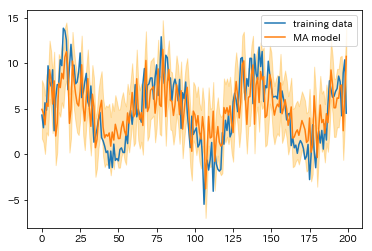

In [6]:
plt.plot(x_train, label='training data')
plt.plot(y_test, label='MA model')
plt.fill_between(np.arange(len(y_test)), y_test-std, y_test+std, alpha=0.3, color='orange')
plt.legend()